In [2]:
import time
import pandas as pd
# import geopandas
from math import sin, cos, sqrt, atan2, radians
from shapely.geometry import box
import ee
import folium
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

In [242]:
class irrigation30():
    
    # Set the max number of samples used in the clustering
    maxSample = 100000
    # Technically, resolution can be a parameter in __init___
    #     But we did not fully test resolutions different from 30 m.
    resolution = 30
    # Reference: https://hess.copernicus.org/articles/19/4441/2015/hessd-12-1329-2015.pdf
    # "If NDVI at peak is less than 0.40, the peak is not counted as cultivation." 
    #     The article uses 10-day composite NDVI while we use montly NDVI.
    #     To account for averaging effect, our threshold is slightly lower than 0.4.
    crop_ndvi_threashold = 0.3
    # Estimated based on http://www.fao.org/3/s2022e/s2022e07.htm#TopOfPage
    water_need_threshold = 100
    # Rename ndvi bands to the following
    ndvi_lst = ['ndvi'+str(i).zfill(2) for i in range(1, 13)]
    # Give descriptive name for the month
    month_lst = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    # List of colors used to plot each cluster
    cluster_color = ['red', 'blue', 'orange', 'yellow', 'darkgreen', 'lightgreen', 'lightblue', 'purple', 'pink', 'lightgray']
    
    def __init__(self, center_lat=43.771114, center_lon=-116.736866, edge_len=0.005, year=2018, maxClusters_set=2):
        
        if edge_len < 0.005:
            raise ValueError('Please select an edge length greater than or equal to 0.005 degree.')
           
        # max edge_len
        # year >= 2018 (first Sentinal2 lauched around mid 2015, and the second was launched in mid 2017)
        # no 12 months of data => kill the process
        ee.Initialize()
        self.center_lat = center_lat
        self.center_lon = center_lon
        self.edge_len = edge_len
        self.year = year
        self.maxClusters_set = maxClusters_set
        self.label = []
        self.comment = dict()
        self.avg_ndvi = np.zeros((2, 12))
        self.temperature_max = []
        self.temperature_min = []
        self.temperature_avg = []
        self.precipitation = []
        self.image = ee.Image()
        self.nClusters = 0
        self.simple_label = []
            
        # Create the bounding box using GEE API
        self.aoi_ee = self.__create_bounding_box_ee()
        # Estimate the area of interest
        self.dist_lon = self.__calc_distance(self.center_lon-self.edge_len/2, self.center_lat, self.center_lon+self.edge_len/2, self.center_lat)
        self.dist_lat = self.__calc_distance(self.center_lon, self.center_lat-self.edge_len/2, self.center_lon, self.center_lat+self.edge_len/2)
        print('The selected area is approximately {:.2f} km by {:.2f} km'.format(self.dist_lon, self.dist_lat))
        
        # Estimate the amount of pixels used in the clustering algorithm
        est_total_pixels = round(self.dist_lat*self.dist_lon*(1000**2)/((irrigation30.resolution)**2))
        self.nSample = min(irrigation30.maxSample,est_total_pixels)
#         print('The estimated percentage of pixels used in the model is {:.0%}.'.format(self.nSample/est_total_pixels))


    def __create_bounding_box_ee(self):
        return ee.Geometry.Rectangle([self.center_lon-self.edge_len/2, self.center_lat-self.edge_len/2, self.center_lon+self.edge_len/2, self.center_lat+self.edge_len/2])
    
    def __create_bounding_box_shapely(self):
        return box(self.center_lon-self.edge_len/2, self.center_lat-self.edge_len/2, self.center_lon+self.edge_len/2, self.center_lat+self.edge_len/2)

    @staticmethod
    def __calc_distance(lon1, lat1, lon2, lat2):
        # Reference: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
        # approximate radius of earth in km
        R = 6373.0
        lon1 = radians(lon1)
        lat1 = radians(lat1)
        lon2 = radians(lon2)
        lat2 = radians(lat2)
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c
        return distance
        
    def __pull_Sentinel2_data(self):
        band_blue = 'B2' #10m
        band_green = 'B3' #10m
        band_red = "B4"  #10m
        band_nir = 'B8'  #10m   
        
        start_date = str(self.year)+'-1-01'
        end_date = str(self.year)+'-12-31'
        
        # Create image collection that contains the area of interest
        Sentinel_IC = (ee.ImageCollection('COPERNICUS/S2')
                         .filterDate(start_date, end_date)
                         .filterBounds(self.aoi_ee)
                         .select(band_nir, band_red))
        
        # Get GFSAD30 image and clip to the area of interest
        GFSAD30_IC = ee.ImageCollection("users/ajsohn/GFSAD30").filterBounds(self.aoi_ee)
        GFSAD30_img = GFSAD30_IC.max().clip(self.aoi_ee)

        def __calc_NDVI(img):
            ndvi = ee.Image(img.normalizedDifference([band_nir, band_red])).rename(["ndvi"]).copyProperties(img, img.propertyNames())
            composite = img.addBands(ndvi)
            return composite
        
        def __get_by_month_data(img):
            months = ee.List.sequence(1,12)
            byMonth = ee.ImageCollection.fromImages(
                months.map(lambda m: img.filter(ee.Filter.calendarRange(m, m, 'month')).median().set('month', m)
                          ).flatten())

            # Take all the satellite bands that have been split into months 
            # as different images in collection (byMonth), and merge into different bands
            def __mergeBands(image, previous):
                return ee.Image(previous).addBands(image).copyProperties(image, image.propertyNames())

            merged = byMonth.iterate(__mergeBands, ee.Image())
            return ee.Image(merged).select(['ndvi']+['ndvi_'+str(i) for i in range(1,12)],
                irrigation30.ndvi_lst)
        
        # Apply the calculation of NDVI
        Sentinel_IC = Sentinel_IC.map(__calc_NDVI).select('ndvi')

        # Get Sentinel-2 monthly data
        # 0 = water, 1 = non-cropland, 2 = cropland, 3 = 'no data'
        byMonth_img = __get_by_month_data(Sentinel_IC) \
                        .addBands(GFSAD30_img.rename(['gfsad30'])) \
                        .addBands(ee.Image("USGS/GFSAD1000_V1").rename(['gfsad1000'])) \
                        .clip(self.aoi_ee)
    
        # Mask the cropland
        cropland = byMonth_img.select('gfsad30').eq(2)
        byMonth_img_masked = byMonth_img.mask(cropland)

        return byMonth_img_masked

    def __pull_TerraClimate_data(self, band, multiplier=1):       
        start_date = str(self.year)+'-1-01'
        end_date = str(self.year)+'-12-31'
        
        # Create image collection that contains the area of interest
        TerraClimate_IC = (ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")
                         .filterDate(start_date, end_date)
                         .filterBounds(self.aoi_ee)
                         .select(band))
        
        def __get_by_month_data(img):
            months = ee.List.sequence(1,12)
            byMonth = ee.ImageCollection.fromImages(
                months.map(lambda m: img.filter(ee.Filter.calendarRange(m, m, 'month')).median().set('month', m)
                          ).flatten())

            # Take all the satellite bands that have been split into months 
            # as different images in collection (byMonth), and merge into different bands
            def __mergeBands(image, previous):
                return ee.Image(previous).addBands(image).copyProperties(image, image.propertyNames())

            merged = byMonth.iterate(__mergeBands, ee.Image())
            return ee.Image(merged).select([band]+[band+'_'+str(i) for i in range(1,12)],
                [band+str(i).zfill(2) for i in range(1, 13)])

        # Get TerraClimate monthly data
        byMonth_img = __get_by_month_data(TerraClimate_IC).clip(self.aoi_ee)
        
        # Calculate the average value by month
        climate_dict = byMonth_img.reduceRegion(reducer=ee.Reducer.mean(), geometry=self.aoi_ee, maxPixels=1e13, scale=irrigation30.resolution).getInfo()
        climate_df = pd.DataFrame([climate_dict], columns=[band+str(i).zfill(2) for i in range(1, 13)], index=[0])
        climate_arr = climate_df.to_numpy()*multiplier
        
        return climate_arr
        

    
    def __identify_peak(self, y_raw):
        # Peaks cannot be identified if it's the first or last number in a series
        # To resolve this issue, we copy the series three times
        y = np.concatenate((y_raw, y_raw, y_raw))
        x = np.linspace(0, 35, num=36, endpoint=True)
        peak_index_raw, peak_value_raw = find_peaks(y, height=irrigation30.crop_ndvi_threashold)
        # Sometimes there are multiple peaks in a single crop season
        # 
        index_diff = np.diff(peak_index_raw)
        peak_grp = [0]
        counter = 0
        for i in index_diff:
            if i == 2:
                peak_grp.append(counter)
            else:
                counter+=1
                peak_grp.append(counter)
        peak_grp_series = pd.Series(peak_grp, name='peak_grp')
        peak_index_series = pd.Series(peak_index_raw, name='peak_index')
        peak_value_series = pd.Series(peak_value_raw['peak_heights'], name='peak_value')
        peak_grp_df = pd.concat([peak_grp_series, peak_index_series, peak_value_series], axis=1)
        peak_grp_agg_df = peak_grp_df.groupby('peak_grp').agg({'peak_index':np.mean, 'peak_value':np.max})
        peak_index = peak_grp_agg_df['peak_index'].to_numpy()
        peak_value = peak_grp_agg_df['peak_value'].to_numpy()
        
        peak_lst = [(int(i-12), irrigation30.month_lst[int(i-12)], j) for i, j in zip(peak_index, peak_value) if i >= 12 and i < 24]
        final_peak_index = [i[0] for i in peak_lst]
        final_peak_month = [i[1] for i in peak_lst]
        final_peak_value = [i[2] for i in peak_lst]
        return final_peak_index, final_peak_month, final_peak_value
        
    def __identify_label(self, cluster_result):
        def __identify_surrounding_month(value, diff):
            new_value = value + diff
            if new_value < 0:
                new_value += 12
            elif new_value >= 12:
                new_value -= 12
            return int(new_value)
        def __calc_effective_precipitation(P):
            # Reference: 
            # Pe = 0.8 P - 25 if P > 75 mm/month
            # Pe = 0.6 P - 10 if P < 75 mm/month
            if P >= 75:
                Pe = 0.8*P-25
            else:
                Pe = max(0.6*P-10, 0)
            return Pe
        
        self.label = []
        for i in range(self.nClusters):
            final_peak_index, final_peak_month, final_peak_value = self.__identify_peak(self.avg_ndvi[i])
            if len(final_peak_index)==0:
                self.label.append('Cluster {}: Rainfed'.format(i))
                self.comment[i] = 'rainfed'
            else:
                temp_label = []
                temp_comment = '{}-crop cycle annually | '.format(len(final_peak_index))
                if len(self.precipitation) == 0:
                    self.precipitation = self.__pull_TerraClimate_data('pr')[0]
                if len(self.temperature_max) == 0:
                    self.temperature_max = self.__pull_TerraClimate_data('tmmx', multiplier=0.1)[0]
                    self.temperature_min = self.__pull_TerraClimate_data('tmmn', multiplier=0.1)[0]
                self.temperature_avg = np.mean([self.temperature_max, self.temperature_min], axis=0)
                for p in range(len(final_peak_index)):
                    p_index = final_peak_index[p]
                    # Calcuate the precipiration the month before the peak and at the peak
                    # Depending on whether it's Fresh harvested crop or Dry harvested crop, the water need after the mid-season is different
                    # Reference: http://www.fao.org/3/s2022e/s2022e02.htm#TopOfPage
                    p_lst = [__identify_surrounding_month(p_index, -1), p_index]
                    pr_mean = self.precipitation[p_lst].mean()
                    # Lower temperature reduces water need
                    # Reference: http://www.fao.org/3/s2022e/s2022e02.htm#TopOfPage
                    if self.temperature_avg[p_lst].mean() < 15:
                        temperature_adj = 0.7
                    else:
                        temperature_adj = 1
                    if pr_mean >= irrigation30.water_need_threshold * temperature_adj:
                        temp_label.append('Rainfed')
                        temp_comment = temp_comment + 'rainfed around {}; '.format(final_peak_month[p])
                    else:
                        temp_label.append('Irrigated')
                        temp_comment = temp_comment + 'irrigated around {}; '.format(final_peak_month[p])
                self.label.append('Cluster {}: '.format(i)+'+'.join(temp_label))
                self.comment[i] = temp_comment
        self.simple_label = ['Irrigated' if 'Irrigated' in i else 'Rainfed' for i in self.label]
        self.image = self.image.addBands(ee.Image(cluster_result.select('cluster')).rename('prediction'))     
        
    def plot_precipitation(self):
        if len(self.precipitation) == 0:
            self.precipitation = self.__pull_TerraClimate_data('pr')[0]
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.plot(irrigation30.month_lst, self.precipitation, label='Precipitation')
        plt.legend()
        
    def plot_temperature_max_min(self):
        if len(self.temperature_max) == 0:
            self.temperature_max = self.__pull_TerraClimate_data('tmmx', multiplier=0.1)[0]
            self.temperature_min = self.__pull_TerraClimate_data('tmmn', multiplier=0.1)[0]
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.plot(irrigation30.month_lst, self.temperature_max, label='Max Temperature')
        plt.plot(irrigation30.month_lst, self.temperature_min, label='Min Temperature')
        plt.legend()

    def fit_predict(self):

        self.image = self.__pull_Sentinel2_data()
        
        training_FC = self.image.cast({'gfsad30':"int8"},['gfsad30', 'gfsad1000']+irrigation30.ndvi_lst)\
                        .stratifiedSample(region=self.aoi_ee, classBand = 'gfsad30', numPoints = self.nSample,
                        classValues = [0, 1, 3], 
                        classPoints = [0, 0, 0],
                        scale=irrigation30.resolution)\
                        .select(irrigation30.ndvi_lst)
        
        # Instantiate the clusterer and train it.
        clusterer = ee.Clusterer.wekaKMeans(self.maxClusters_set).train(training_FC, inputProperties=irrigation30.ndvi_lst)
        # wekaCascadeKMeans takes much longer to run when maxClusters is greater than minClusters
#         clusterer = ee.Clusterer.wekaCascadeKMeans(minClusters=2, maxClusters=self.maxClusters_set).train(training_FC, inputProperties=irrigation30.ndvi_lst)
#         clusterer = ee.Clusterer.wekaXMeans(minClusters=2, maxClusters=self.maxClusters_set).train(training_FC, inputProperties=irrigation30.ndvi_lst)

        # Cluster the input using the trained clusterer.
        cluster_result = self.image.cluster(clusterer)
        
        print('Model building...')
        cluster_output = dict()
        for i in range(0, self.maxClusters_set):
            cluster_output[i] = self.image.select(irrigation30.ndvi_lst).mask(cluster_result.select('cluster').eq(i)).reduceRegion(reducer=ee.Reducer.mean(), geometry=self.aoi_ee, maxPixels=1e13, scale=30).getInfo()
            if cluster_output[i]['ndvi01']==None:
                self.nClusters = i
                del cluster_output[i]
                break
            elif i == self.maxClusters_set-1:
                self.nClusters = self.maxClusters_set
        
        # Reference: https://stackoverflow.com/questions/45194934/eval-fails-in-list-comprehension
        globs = globals()
        locs = locals()
        cluster_df = pd.DataFrame([eval('cluster_output[{}]'.format(i), globs, locs) for i in range(0,self.nClusters)], columns=irrigation30.ndvi_lst, index=['Cluster_'+str(i) for i in range(0,self.nClusters)])

        self.avg_ndvi = cluster_df.to_numpy()

        self.__identify_label(cluster_result)
        
        print('Model complete')
        
    def plot_map(self):
        def add_ee_layer(self, ee_object, vis_params, show, name):
            try:    
                if isinstance(ee_object, ee.image.Image):    
                    map_id_dict = ee.Image(ee_object).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                        tiles = map_id_dict['tile_fetcher'].url_format,
                        attr = 'Google Earth Engine',
                        name = name,
                        overlay = True,
                        control = True,
                        show = show
                        ).add_to(self)
                elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
                    ee_object_new = ee_object.median()
                    map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                        tiles = map_id_dict['tile_fetcher'].url_format,
                        attr = 'Google Earth Engine',
                        name = name,
                        overlay = True,
                        control = True,
                        show = show
                        ).add_to(self)
                elif isinstance(ee_object, ee.geometry.Geometry):    
                    folium.GeoJson(
                            data = ee_object.getInfo(),
                            name = name,
                            overlay = True,
                            control = True
                        ).add_to(self)
                elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
                    ee_object_new = ee.Image().paint(ee_object, 0, 2)
                    map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                            tiles = map_id_dict['tile_fetcher'].url_format,
                            attr = 'Google Earth Engine',
                            name = name,
                            overlay = True,
                            control = True,
                            show = show
                        ).add_to(self)

            except:
                print("Could not display {}".format(name))

        # Add EE drawing method to folium.
        folium.Map.add_ee_layer = add_ee_layer

        myMap = folium.Map(location=[self.center_lat, self.center_lon], zoom_start=10)
        aoi_shapely = self.__create_bounding_box_shapely()
        folium.GeoJson(aoi_shapely, name="Area of Interest").add_to(myMap)
        visParams = {'min':0, 'max':self.nClusters-1, 'palette': irrigation30.cluster_color[:self.nClusters]}
        myMap.add_ee_layer(self.image.select('prediction'), visParams, show=True, name='Prediction')
        #     0: Non-croplands (black)
        #     1: Croplands: irrigation major (green)
        #     2: Croplands: irrigation minor (lighter green)
        #     3: Croplands: rainfed (yellow)
        #     4: Croplands: rainfed, minor fragments (yellow orange)
        #     5: Croplands: rainfed, rainfed, very minor fragments (orange)
        visParams = {'min':0, 'max':5, 'palette':['black', 'green', 'a9e1a9', 'yellow', 'ffdb00', '#ffa500']}
        myMap.add_ee_layer(self.image.select('gfsad1000'), visParams, show=False, name='GFSAD1000')
        visParams = {'min':0, 'max':1, 'palette': ['red', 'yellow', 'green']}
        for i in range(1, 13):
            temp_band = 'ndvi'+str(i).zfill(2) 
            month_label = irrigation30.month_lst[i-1]
            myMap.add_ee_layer(self.image.select(temp_band), visParams, show=False, name='NDVI '+month_label)
        myMap.add_child(folium.LayerControl())
        folium.Marker([self.center_lat, self.center_lon], tooltip='center').add_to(myMap)
        
        print('============ Prediction Layer Legend ============')
        # print the comments for each cluster
        for i in range(self.nClusters):
            print('Cluster {} ({}): {}'.format(i, irrigation30.cluster_color[i], self.comment[i]))
        print('============ GFSAD1000 Layer Legend ============')
        print('Croplands: irrigation major (green)')
        print('Croplands: irrigation minor (lighter green)')
        print('Croplands: rainfed (yellow)')
        print('Croplands: rainfed, minor fragments (yellow orange)')
        print('Croplands: rainfed, rainfed, very minor fragments (orange)')
        print('================================================')
        return myMap
    
    def plot_avg_ndvi(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        for i in range(0, self.nClusters):
            plt.plot(irrigation30.month_lst, self.avg_ndvi[i], label=self.label[i], color=irrigation30.cluster_color[i])
        plt.legend()
    

In [243]:
# (lon, lat)
# [82.121452, 21.706688],     // C01 (India): Doesn't look quite right.
                                              # Agree; the division feel arbitrary; both matched precipitation trend though
# [-94.46643, 48.76297],      // C02 (Canada): S2-Q1+Q4 layer is white/black. "Satellite" looks better. Irrigation is okay.
# [-105.69772, 49.316722],    // C03 (Canada): SWAP OUT WITH IDAHO.
# [10.640815, 52.185072],     // C04 (Germany): Strange S2 layers, otherwise good result. Look at flip of cropland in Q2 and Q3! Irrigation seems to coincide with Q2. 
#                                             # (one in May and the other in July) One rainfed and one irrigation or both irrigation?
# [10.7584699, 52.2058339],   // C05 (Germany): Doesn't seem right. 
# [33.857852, 46.539389],     // C06 (Ukraine): WEIRD RESULT. S2 seasonal flip-flops (Q2 and Q3 flip flop, then Q4 confusion). NDVI peaks at different seasons for each cluster. Heuristic mismatch!
#                                             # Maybe both are irrgated but at different times (April, July, and October), 3 clusters?
# [36.58565, 47.0838],        // C07 (Ukraine): Looks okay?
# [38.34523, 30.22176],       // C08 (Saudi Arabia): Looks great. Although definitely depends on season.
# [-64.075199, -31.950112],   // C09 (Argentina): NEW. Irrigation labels make no sense. Clusters have almost identical signatures.
# [67.359826, 43.55412],      // C10 (Uzbekistan): Mostly good. Although clusters seem to select areas that peak at different seasons (Q2 vs Q3). 
# [-46.2607, -11.93067]       // C11 (Brazil): Tricky case. Mostly non-cropland. 
# [-116.736866, 43.771114]    // Idaho

In [141]:
# Adam's #1 (India): should be rainfed
test = irrigation30(center_lat=15.8005146, center_lon=77.97976826, edge_len=0.05, maxClusters_set=2)

The selected area is approximately 5.35 km by 5.56 km


In [116]:
# Adam's #2 (India): should be irrigated
# Cluster 0: 2-crop annually | irrigated around Feb; irrigated around Oct; 
# Cluster 1: 1-crop annually | irrigated around Oct; 
test = irrigation30(center_lat=16.61968558, center_lon=77.98163937, edge_len=0.05)

The selected area is approximately 5.33 km by 5.56 km


In [123]:
# Adam's #3 (India): GFSAD30+ and crowdsource are inconsistent
test = irrigation30(center_lat=14.62018602, center_lon=78.57053589, edge_len=0.05, maxClusters_set=2)

The selected area is approximately 5.38 km by 5.56 km


In [244]:
# Adam's #4 (India): should be rainfed
test = irrigation30(center_lat=15.36508304, center_lon=77.51866646, edge_len=0.05)

The selected area is approximately 5.36 km by 5.56 km


In [131]:
# Adam's #5 (India): should be irrigated
test = irrigation30(center_lat=14.4920294, center_lon=80.0033313, edge_len=0.05)

The selected area is approximately 5.38 km by 5.56 km


In [178]:
################################################################### gfsad30+: rainfed
# Adam's #6 (Australia): should be rainfed
# peaks:0.66313885 and 0.52 (2018)???
# precipitation looks low for rainfed. hmmm......
test = irrigation30(center_lat=-33.83599, center_lon=138.059135, edge_len=0.05, year=2017, maxClusters_set=2)

The selected area is approximately 4.62 km by 5.56 km


In [194]:
# Adam's #7 (Australia): should be rainfed
test = irrigation30(center_lat=-30.935931, center_lon=116.087147, edge_len=0.05, year=2017)

The selected area is approximately 4.77 km by 5.56 km


In [203]:
# Adam's #8 (Australia): should be irrigated
test = irrigation30(center_lat=-34.28572, center_lon=146.11491, edge_len=0.05, year=2017)

The selected area is approximately 4.60 km by 5.56 km


In [211]:
# Adam's #9 (Australia): should be irrigated
test = irrigation30(center_lat=-35.951044, center_lon=146.559336, edge_len=0.05, year=2017)

The selected area is approximately 4.50 km by 5.56 km


In [212]:
################################################################### crowdsource: irrigate, gfsad30+:irrigate (circle), rain
# Australia - Adam's #10, multiple dip, peaks:0.57816652 and 0.3964???
test = irrigation30(center_lat=-35.107376, center_lon=147.261322, edge_len=0.05, year=2017)

The selected area is approximately 4.55 km by 5.56 km


In [220]:
# Ukraine - Will's #6, both clsuters are irrigated. new algorithm is correct
test = irrigation30(center_lat=46.539389, center_lon=33.857852, edge_len=0.05, maxClusters_set=2)

The selected area is approximately 3.83 km by 5.56 km


In [227]:
# Ukraine - Will's #7, multiple dips are handled, new algorithm looks good.
# one irrigated, one rainfed
test = irrigation30(center_lat=47.0838, center_lon=36.58565, edge_len=0.05)

The selected area is approximately 3.79 km by 5.56 km


In [7]:
# India - compared against GFSAD30+ (GFSAD30+ marked some villedge areas as irrigated)
# test = irrigation30(center_lat=21.628880, center_lon=85.585623, edge_len=0.05)

In [8]:
# India - 2 crop (Lorenzo: Jan is irrigated for both clusters; July is rainfed + irrigation)
# test = irrigation30(center_lat=23.58014, center_lon=73.28559, edge_len=0.05)

In [234]:
# Germary - Will's #4, (one in May and the other in July, both irrigated). new algorithm is correct
# Cluster 0: 1-crop annually | irrigated around May; 
# Cluster 1: 1-crop annually | irrigated around Jul; 
test = irrigation30(center_lat=52.185072, center_lon=10.640815, edge_len=0.05)

The selected area is approximately 3.41 km by 5.56 km


In [14]:
# Argentina - Will's #9, both clusters are irrigated, the new algorithm is correct
# test = irrigation30(center_lat=-31.950112, center_lon=-64.075199, edge_len=0.05)

In [15]:
# Check precipitation resonability
# India
# https://weather-and-climate.com/average-monthly-Rainfall-Temperature-Sunshine,cochin,India
# test = irrigation30(center_lat=9.995191, center_lon=76.340577, edge_len=0.05)

In [16]:
# Vietnam with edge length of 0.1?
# left: 01, 02, 06, 12
# right: 01, 02, 05, 10
# bottom: 02, 03, 07, 12
# test = irrigation30(center_lat=10.716019771291887, center_lon=105.50046138315179, edge_len=0.05)

In [245]:
%%time
test.fit_predict()

Model building...
Model complete
CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 13.7 s


In [246]:
%%time
test.plot_map()

============ Prediction Layer Legend ============
Cluster 0 (red): rainfed
Cluster 1 (blue): 1-crop cycle annually | rainfed around Oct; 
============ GFSAD1000 Layer Legend ============
Croplands: irrigation major (green)
Croplands: irrigation minor (lighter green)
Croplands: rainfed (yellow)
Croplands: rainfed, minor fragments (yellow orange)
Croplands: rainfed, rainfed, very minor fragments (orange)
CPU times: user 180 ms, sys: 20 ms, total: 200 ms
Wall time: 8.88 s


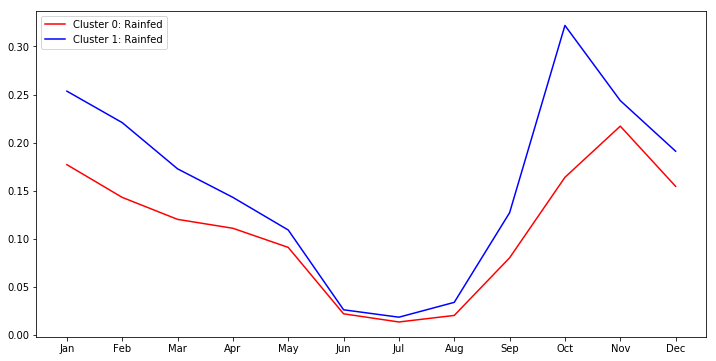

In [247]:
test.plot_avg_ndvi()

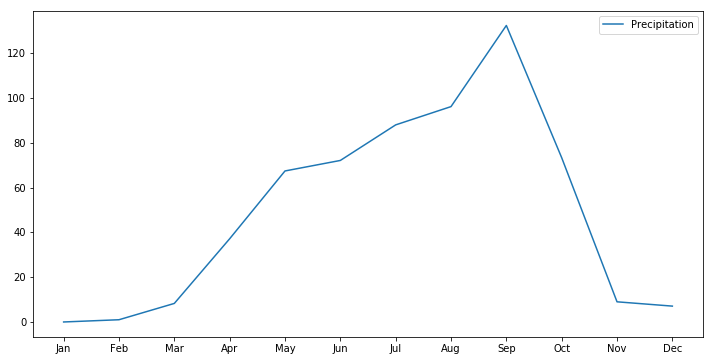

In [248]:
test.plot_precipitation()
# peak but too low? 800~600/4 = 200, at least 100mm. 5-6mm per day
# Precipitation for AUS is sometimes bad

In [249]:
np.sum(test.precipitation)

591.7746495400835

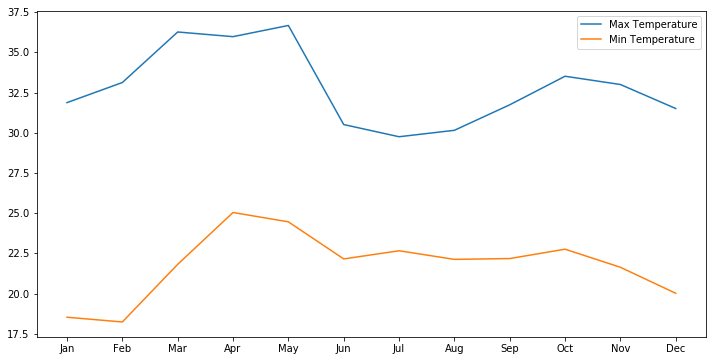

In [250]:
test.plot_temperature_max_min()
# appropriate temperature for crop? 15-35? Use Avg temperature

In [251]:
test.simple_label

['Rainfed', 'Rainfed']